### Notebook for end to end classification

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, precision_score, roc_auc_score, roc_curve, accuracy_score

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/heart_failure_clinical_records_dataset.csv')

In [ ]:
df.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

In [ ]:
# Quick Inspection

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [ ]:
import seaborn as sns

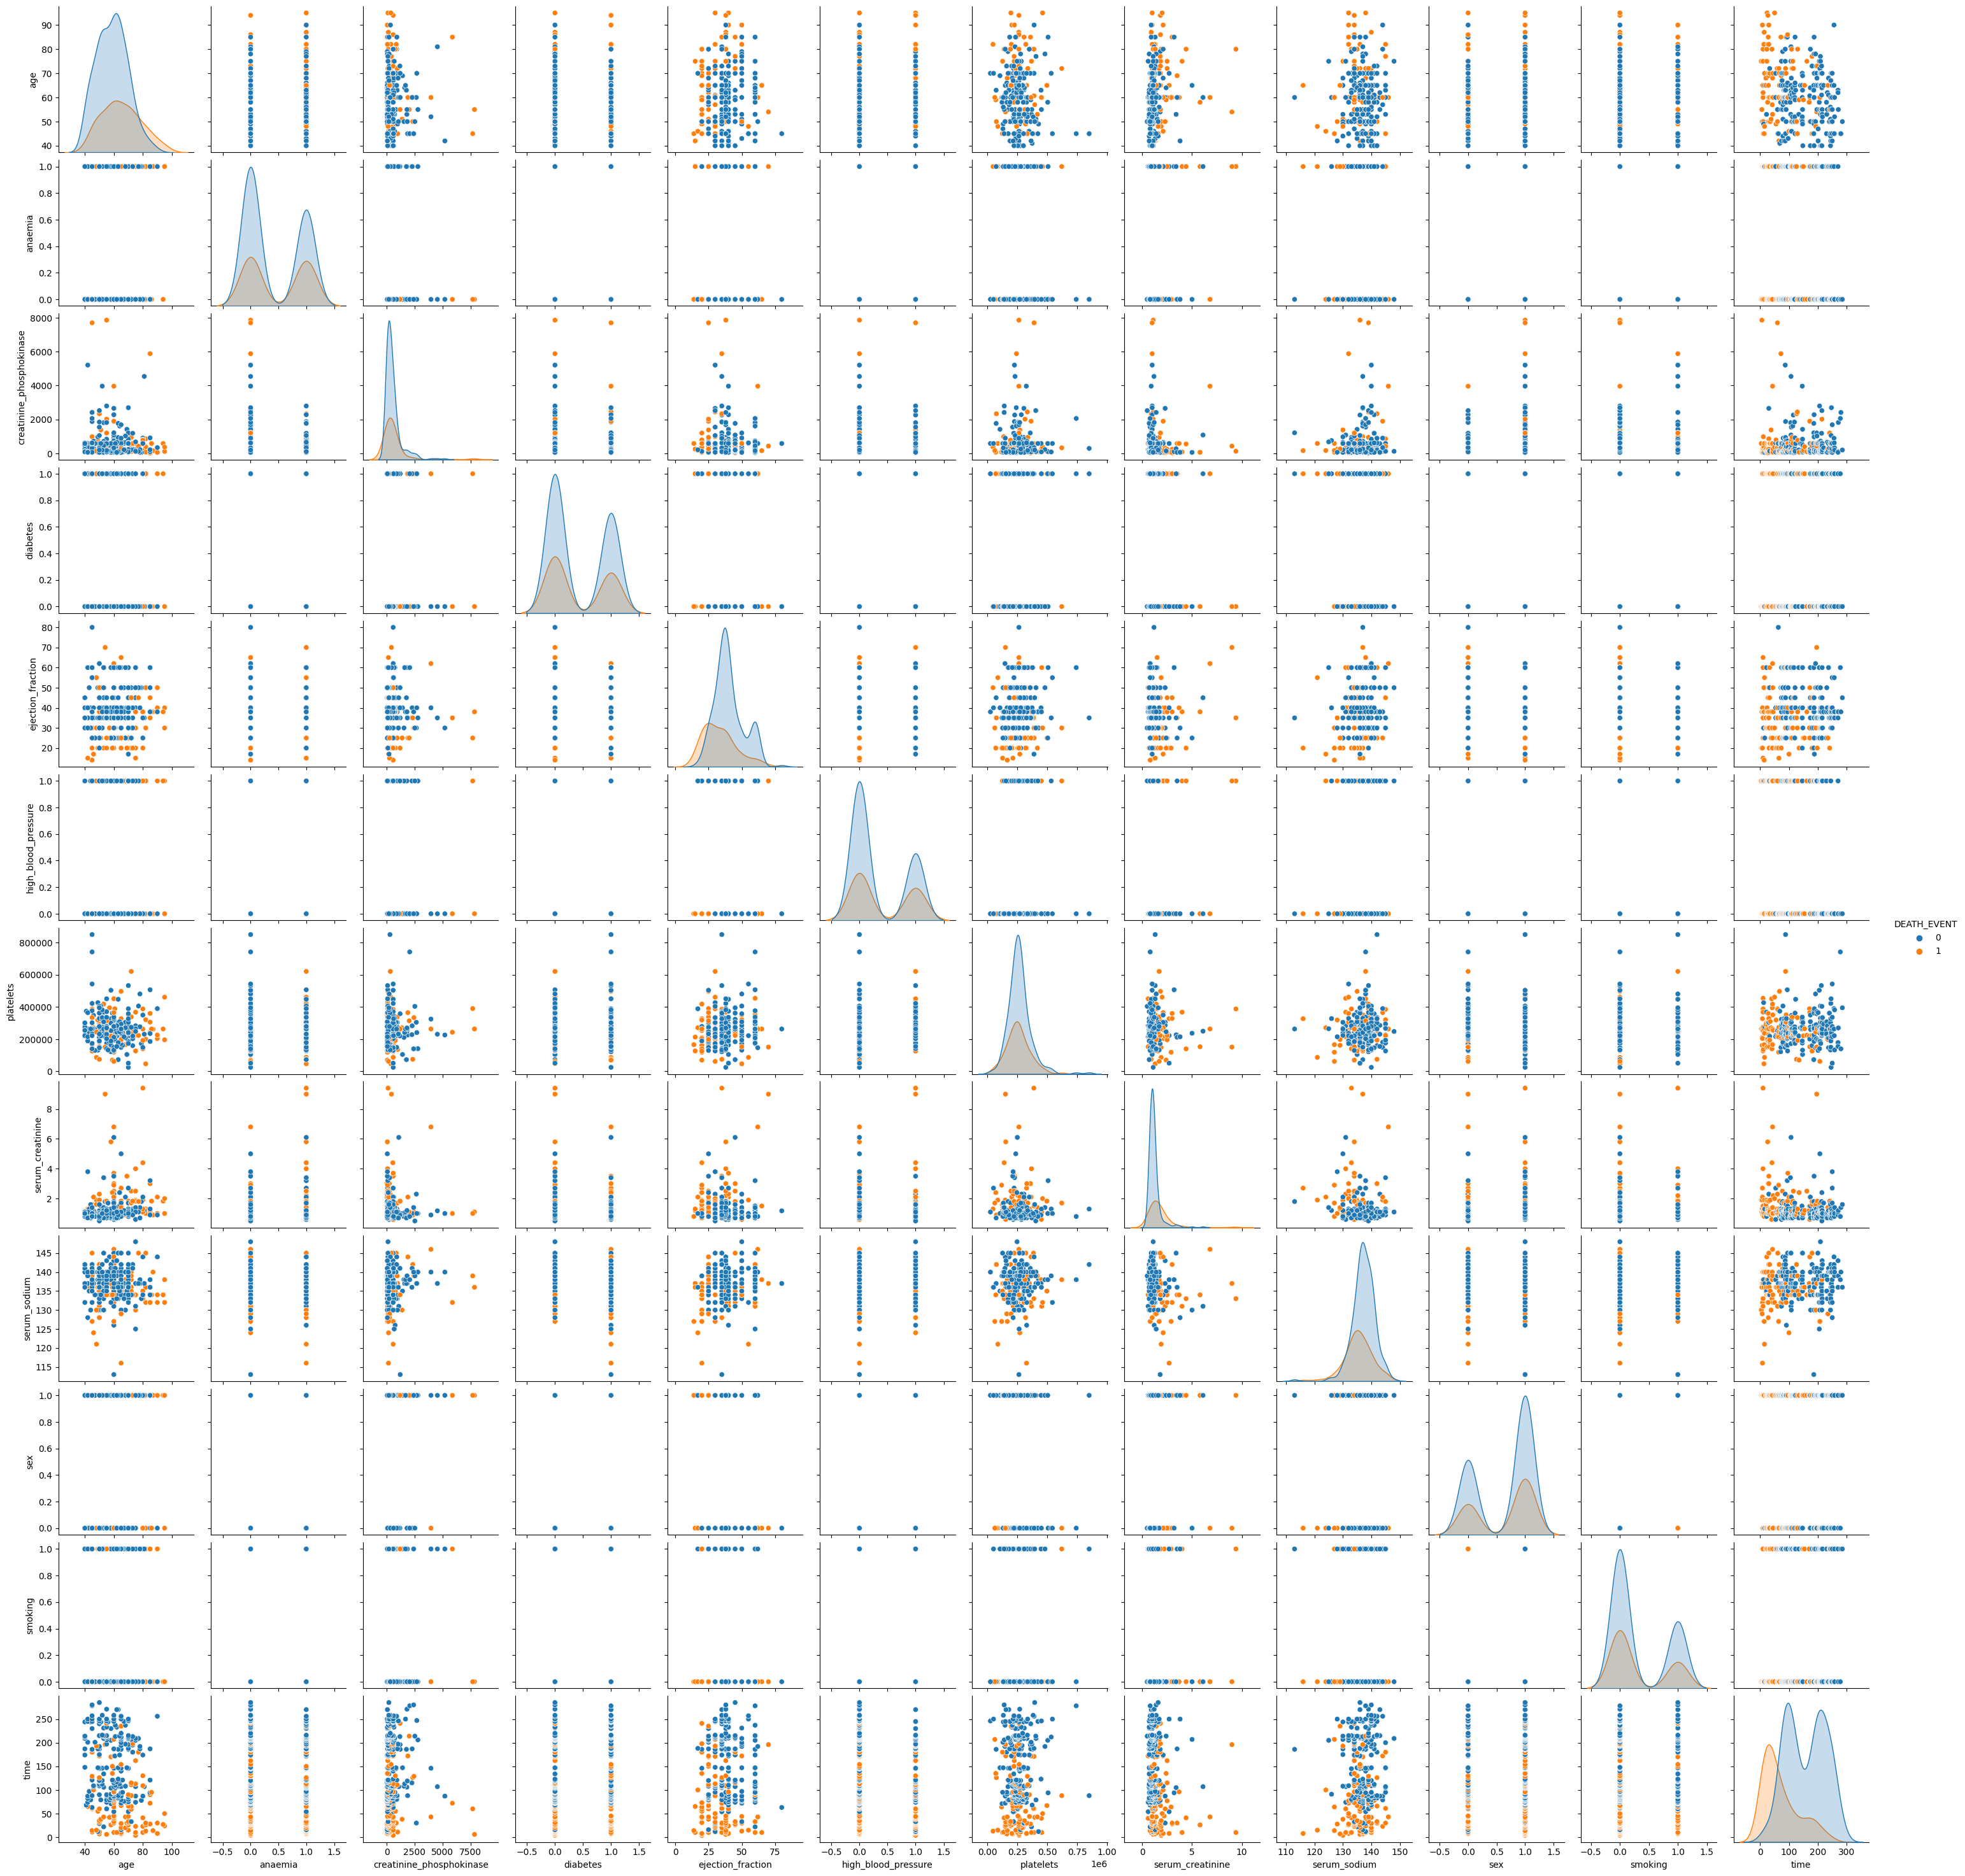

In [ ]:
sns.pairplot(df, hue = 'DEATH_EVENT')

<Axes: xlabel='DEATH_EVENT', ylabel='age'>

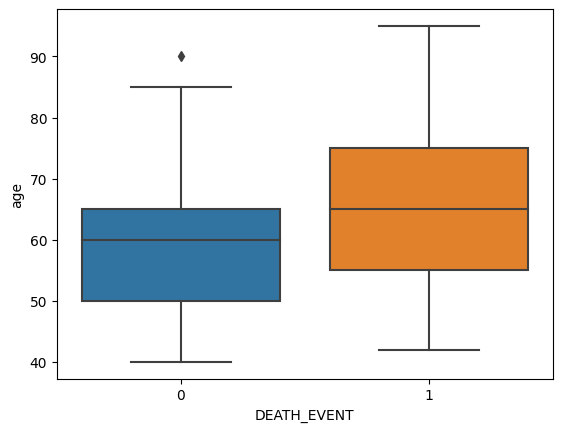

In [ ]:
 # Investigate 1 by 1
# Age first
 sns.boxplot(x='DEATH_EVENT', y='age', data=df)

<Axes: xlabel='DEATH_EVENT', ylabel='creatinine_phosphokinase'>

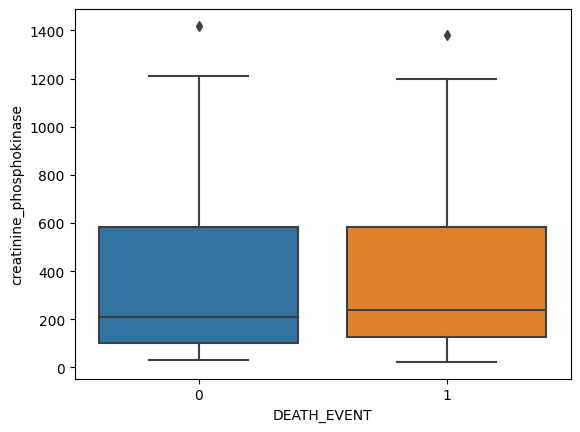

In [ ]:
# Creatinine first
sns.boxplot(x='DEATH_EVENT', y='creatinine_phosphokinase', data=df[df['creatinine_phosphokinase']<=1500])

<Axes: xlabel='DEATH_EVENT', ylabel='ejection_fraction'>

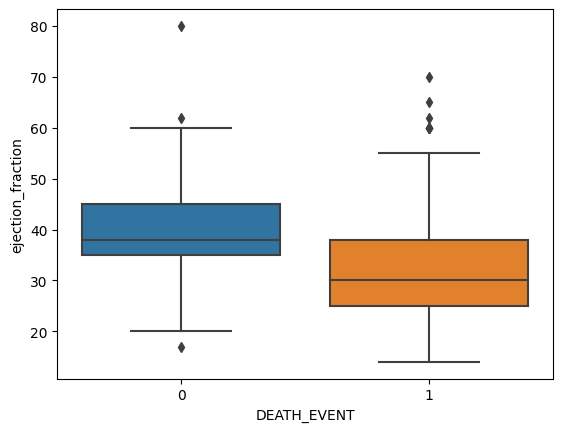

In [ ]:
# Ejection Fraction (amount of blood heart pumps out each beat) first
sns.boxplot(x='DEATH_EVENT', y='ejection_fraction', data=df)

<Axes: xlabel='DEATH_EVENT', ylabel='serum_creatinine'>

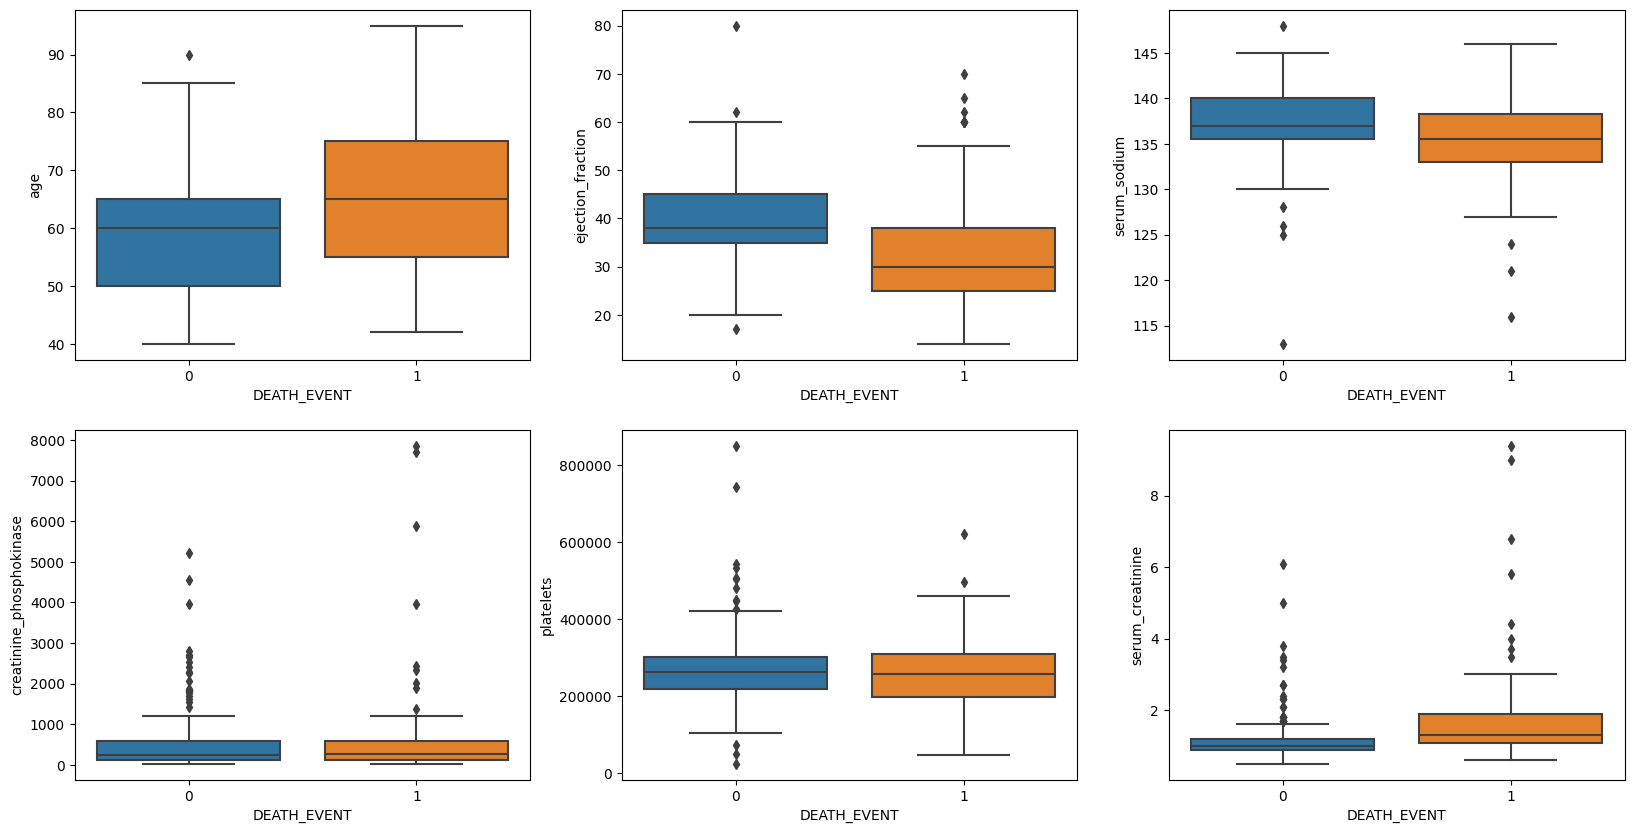

In [ ]:
import matplotlib.pyplot as plt

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,10))
sns.boxplot(x='DEATH_EVENT', y='age', ax=ax1, data=df)
sns.boxplot(x='DEATH_EVENT', y='ejection_fraction', ax=ax2, data=df)
sns.boxplot(x='DEATH_EVENT', y='serum_sodium', ax=ax3, data=df)
sns.boxplot(x='DEATH_EVENT', y='creatinine_phosphokinase', ax=ax4, data=df)
sns.boxplot(x='DEATH_EVENT', y='platelets', ax=ax5, data=df)
sns.boxplot(x='DEATH_EVENT', y='serum_creatinine', ax=ax6, data=df)

In [ ]:
# initial hypothesis> age, serum_creatinine, serum_sodium, ejection_fraction are mot important
# look at categoricals

df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [ ]:
df_anaemia = df.groupby(['DEATH_EVENT','anaemia'])[['sex']].count().unstack()
df_anaemia['total'] = df_anaemia['sex'][0] + df_anaemia['sex'][1]
df_anaemia['percent_0'] = df_anaemia['sex'][0] / df_anaemia['total']
df_anaemia['percent_1'] = df_anaemia['sex'][1] / df_anaemia['total']
df_anaemia

sex     total percent_0 percent_1
anaemia        0   1                          
DEATH_EVENT                                   
0            120  83   203  0.591133  0.408867
1             50  46    96  0.520833  0.479167

In [ ]:
df_diabetes = df.groupby(['DEATH_EVENT','diabetes'])[['sex']].count().unstack()
df_diabetes['total'] = df_diabetes['sex'][0] + df_diabetes['sex'][1]
df_diabetes['percent_0'] = df_diabetes['sex'][0] / df_diabetes['total']
df_diabetes['percent_1'] = df_diabetes['sex'][1] / df_diabetes['total']
df_diabetes

sex     total percent_0 percent_1
diabetes       0   1                          
DEATH_EVENT                                   
0            118  85   203  0.581281  0.418719
1             56  40    96  0.583333  0.416667

In [ ]:
df_high_blood_pressure = df.groupby(['DEATH_EVENT','high_blood_pressure'])[['sex']].count().unstack()
df_high_blood_pressure['total'] = df_high_blood_pressure['sex'][0] + df_high_blood_pressure['sex'][1]
df_high_blood_pressure['percent_0'] = df_high_blood_pressure['sex'][0] / df_high_blood_pressure['total']
df_high_blood_pressure['percent_1'] = df_high_blood_pressure['sex'][1] / df_high_blood_pressure['total']
df_high_blood_pressure

sex     total percent_0 percent_1
high_blood_pressure    0   1                          
DEATH_EVENT                                           
0                    137  66   203  0.674877  0.325123
1                     57  39    96  0.593750  0.406250

In [ ]:
df_sex = df.groupby(['DEATH_EVENT','sex'])[['smoking']].count().unstack()
df_sex['total'] = df_sex['smoking'][0] + df_sex['smoking'][1]
df_sex['percent_0'] = df_sex['smoking'][0] / df_sex['total']
df_sex['percent_1'] = df_sex['smoking'][1] / df_sex['total']
df_sex


smoking      total percent_0 percent_1
sex               0    1                          
DEATH_EVENT                                       
0                71  132   203  0.349754  0.650246
1                34   62    96  0.354167  0.645833

In [ ]:
df_smoking = df.groupby(['DEATH_EVENT','smoking'])[['sex']].count().unstack()
df_smoking['total'] = df_smoking['sex'][0] + df_smoking['sex'][1]
df_smoking['percent_0'] = df_smoking['sex'][0] / df_smoking['total']
df_smoking['percent_1'] = df_smoking['sex'][1] / df_smoking['total']
df_smoking

sex     total percent_0 percent_1
smoking        0   1                          
DEATH_EVENT                                   
0            137  66   203  0.674877  0.325123
1             66  30    96  0.687500  0.312500

In [ ]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [ ]:
# refined hypothesis> age, serum_creatinine, serum_sodium, ejection_fraction, aneimia, high_blood_pressure are most important

log = LogisticRegression()
log.fit(df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking']], df['DEATH_EVENT'])


LogisticRegression()

In [ ]:
pred = log.predict(df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking']])

In [ ]:
print(accuracy_score(pred,df['DEATH_EVENT']))
print(f1_score(pred,df['DEATH_EVENT']))
print(precision_score(pred,df['DEATH_EVENT']))
print(recall_score(pred,df['DEATH_EVENT']))

0.7558528428093646
0.5100671140939597
0.3958333333333333
0.7169811320754716


In [ ]:
pd.DataFrame([log.feature_names_in_,log.coef_.flatten()]).T

0         1
0                        age  0.062247
1                    anaemia  0.000792
2   creatinine_phosphokinase  0.000202
3                   diabetes  0.000028
4          ejection_fraction -0.060873
5        high_blood_pressure  0.000871
6                  platelets      -0.0
7           serum_creatinine   0.00628
8               serum_sodium -0.017948
9                        sex -0.000196
10                   smoking -0.000131

In [ ]:
x = df[['age', 'anaemia','ejection_fraction', 'high_blood_pressure',
       'serum_creatinine', 'serum_sodium']]
y = df['DEATH_EVENT']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1234)

In [ ]:
from sklearn.svm import SVC

In [ ]:
knn = KNeighborsClassifier()
log = LogisticRegression()
nb = GaussianNB()
svc = SVC(kernel='linear')


In [ ]:
knn.fit(x_train, y_train)
log.fit(x_train, y_train)
nb.fit(x_train, y_train)
svc.fit(x_train, y_train)

SVC(kernel='linear')

In [ ]:
pred_knn = knn.predict(x_test)
pred_log = log.predict(x_test)
pred_nb = nb.predict(x_test)
pred_sv = svc.predict(x_test)

In [ ]:
print(f1_score(pred_knn,y_test))
print(f1_score(pred_log,y_test))
print(f1_score(pred_nb,y_test))
print(f1_score(pred_sv,y_test))



0.42424242424242425
0.6
0.4166666666666667
0.5714285714285714


In [ ]:
pred_sv

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [ ]:
# Narrow down modeling to SVC and LogReg
# Finding best params for SVC
params_svc = {'kernel':['rbf', 'linear', 'poly','sigmoid']}

randomsearch_svc = RandomizedSearchCV(svc, params_svc, cv=10, n_iter= 15, scoring='f1')
randomsearch_svc.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=15. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=SVC(kernel='linear'), n_iter=15,
                   param_distributions={'kernel': ['rbf', 'linear', 'poly',
                                                   'sigmoid']},
                   scoring='f1')

In [ ]:
randomsearch_svc.best_params_


{'kernel': 'linear'}

In [ ]:
log_pred_prob = log.predict_proba(x_test)

In [ ]:
fpr, tpr, tresholds = roc_curve(y_test,log_pred_prob[:,1])

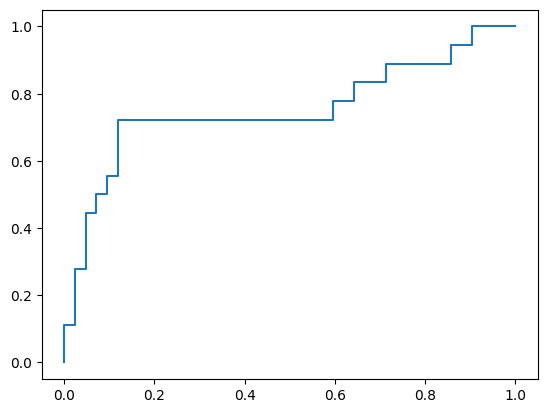

In [ ]:
plt.plot(fpr,tpr)

In [ ]:
gmeans = np.sqrt(tpr*(1-fpr))

In [ ]:
print(tresholds[np.argmax(gmeans)])
print(gmeans[np.argmax(gmeans)])

0.36829385617577914
0.7976486609049038


In [ ]:
tresholds

array([1.80773685, 0.80773685, 0.77777272, 0.74887294, 0.62550842,
       0.57983109, 0.52970836, 0.52814469, 0.50772811, 0.45458005,
       0.40915417, 0.39765438, 0.36829386, 0.19409739, 0.19337849,
       0.15409703, 0.1495941 , 0.13225883, 0.12980636, 0.0801131 ,
       0.057733  , 0.04778627, 0.04269533, 0.0167365 ])

In [ ]:
gmeans

array([0.        , 0.23570226, 0.33333333, 0.32934117, 0.52073412,
       0.5143445 , 0.65060005, 0.64241607, 0.68138514, 0.67259271,
       0.70897497, 0.69958415, 0.79764866, 0.54067369, 0.56108361,
       0.52704628, 0.54554473, 0.48795004, 0.50395263, 0.35634832,
       0.36731544, 0.2999118 , 0.3086067 , 0.        ])

In [ ]:
y_pred_new = []
for i in log_pred_prob[:,1]:
  if i < 0.36829385617577914:
    y_pred_new.append(0)
  else:
    y_pred_new.append(1)

In [ ]:
print(f1_score(y_pred_new,y_test))

0.7222222222222222


In [ ]:
fpr, tpr, tresholds = roc_curve(y_test,y_pred_new)

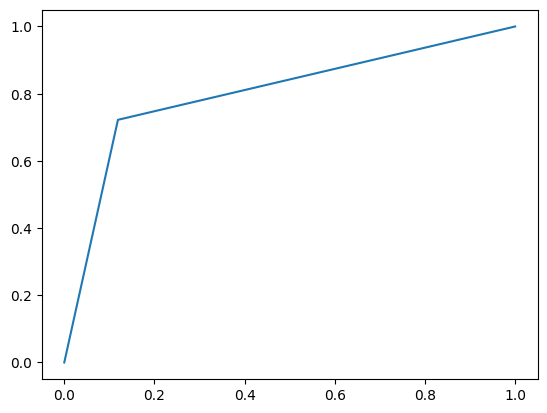

In [ ]:
plt.plot(fpr,tpr)